# Analyzing the benchmarks with 2 covariates

In [257]:
# Setup
import pandas as pd
import numpy as np
import os
import pickle as pkl
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plot_path = "./plots/"

Functions for getting classification metrics for every result based on ground truth

In [211]:
def get_scores(df, add=""):
    """
    Calculates extended binary classification summary statistics, such as TPR, TNR, youden index, f1-score, MCC

    Parameters
    ----------
    df: DataFrame
        Must contain columns tp, tn, fp, fn

    Returns
    -------
    df: DataFrame
        Same df with added columns tpr, tnr, precision, accuracy, youden, f1_score, mcc
    """
    tp = df[f"tp{add}"].astype("float64")
    tn = df[f"tn{add}"].astype("float64")
    fp = df[f"fp{add}"].astype("float64")
    fn = df[f"fn{add}"].astype("float64")

    tpr = (tp / (tp + fn)).fillna(0)
    df[f"tpr{add}"] = tpr
    tnr = (tn / (tn + fp)).fillna(0)
    df[f"tnr{add}"] = tnr
    precision = (tp / (tp + fp)).fillna(0)
    df[f"precision{add}"] = precision
    fdr = (fp / (tp + fp)).fillna(0)
    df[f"fdr{add}"] = fdr
    acc = ((tp + tn) / (tp + tn + fp + fn)).fillna(0)
    df[f"accuracy{add}"] = acc

    df[f"youden{add}"] = tpr + tnr - 1
    df[f"f1_score{add}"] = 2 * (tpr * precision / (tpr + precision)).fillna(0)

    df[f"mcc{add}"] = (((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))).fillna(0)

    return df


def classify(row):
    p = row["num_otus"]

    gt = np.zeros(p)
    gt2 = np.zeros(p)

    if type(row["effect_otus"]) == str:
        eff = eval(row["effect_otus"].replace("[ ", "[").replace("  ", " ").replace(" ", ", "))
    else:
        eff = row["effect_otus"]
    gt[eff] = 1

    gt2[np.arange(13, 24, 1)] = 1


    pred = np.zeros(p)
    pred_2 = np.zeros(p)

    res = [int(x) for x in eval(row["result_otus"])]
    pred[[x for x in res if x < p]] = 1
    pred_2[[x-p for x in res if x >= p and x < 2*p]] = 1
    pred_3 = [x-2*p for x in res if x >= 2*p]

    tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
    tn2, fp2, fn2, tp2 = confusion_matrix(gt2, pred_2).ravel()
    tn3 = p-len(pred_3)
    fp3 = len(pred_3)
    fn3 = 0
    tp3 = 0
    return tp, tn, fp, fn, tp2, tn2, fn2, fp2, tn3, fp3, fn3, tp3

In [212]:
tree_agg_path = "./results/"

tree_agg_res = []

for f in os.listdir(tree_agg_path):
    if f.startswith("result_df"):
        tree_agg_res.append(pd.read_csv(tree_agg_path + f, index_col=0))

tree_agg_df = pd.concat(tree_agg_res)
tree_agg_df

,model,reg_method,lambda,phi,result_nodes,result_otus,mean_log_prob,acc_rate,num_samples,effect_size,num_otus,dataset_id
0,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1530.117979,0.86335,10,0.5,30,10
1,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1521.796781,0.85635,10,0.5,30,11
2,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1532.198723,0.83650,10,0.5,30,12
3,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1528.992981,0.85235,10,0.5,30,13
4,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1634.155036,0.85245,10,0.5,30,14
...,...,...,...,...,...,...,...,...,...,...,...,...
5,tree_agg,new_3,NaN,-5.0,[],[],-1391.552435,0.91045,10,0.5,30,15
6,tree_agg,new_3,NaN,-5.0,[],[],-1135.301315,0.86235,10,0.5,30,16
7,tree_agg,new_3,NaN,-5.0,['33'],"[13, 14, 15, 16]",-1366.250397,0.83165,10,0.5,30,17
8,tree_agg,new_3,NaN,-5.0,"['33', '39']","[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]",-1371.497092,0.83360,10,0.5,30,18


In [213]:
ground_truth = {
    10: ([0, 4, 12], [0, 4, 7, 8]),
    30: ([33, 7, 0], [0, 7, 13, 14, 15, 16]),
    50: ([61, 40, 5], [5, 40, 44, 45, 46, 47]),
    100: ([113, 72, 28], [72, 55, 56, 57, 58, 28])
}

tree_agg_df["effect_nodes"] = [ground_truth[x][0] for x in tree_agg_df["num_otus"]]
tree_agg_df["effect_otus"] = [ground_truth[x][1] for x in tree_agg_df["num_otus"]]
tree_agg_df

,model,reg_method,lambda,phi,result_nodes,result_otus,mean_log_prob,acc_rate,num_samples,effect_size,num_otus,dataset_id,effect_nodes,effect_otus
0,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1530.117979,0.86335,10,0.5,30,10,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
1,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1521.796781,0.85635,10,0.5,30,11,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
2,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1532.198723,0.83650,10,0.5,30,12,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
3,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1528.992981,0.85235,10,0.5,30,13,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
4,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1634.155036,0.85245,10,0.5,30,14,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,tree_agg,new_3,NaN,-5.0,[],[],-1391.552435,0.91045,10,0.5,30,15,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
6,tree_agg,new_3,NaN,-5.0,[],[],-1135.301315,0.86235,10,0.5,30,16,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
7,tree_agg,new_3,NaN,-5.0,['33'],"[13, 14, 15, 16]",-1366.250397,0.83165,10,0.5,30,17,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
8,tree_agg,new_3,NaN,-5.0,"['33', '39']","[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]",-1371.497092,0.83360,10,0.5,30,18,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"


In [214]:
classes = tree_agg_df.apply(classify, axis=1)

tree_agg_df["tp"] = [x[0] for x in classes]
tree_agg_df["tn"] = [x[1] for x in classes]
tree_agg_df["fp"] = [x[2] for x in classes]
tree_agg_df["fn"] = [x[3] for x in classes]
tree_agg_df["tp2"] = [x[4] for x in classes]
tree_agg_df["tn2"] = [x[5] for x in classes]
tree_agg_df["fp2"] = [x[6] for x in classes]
tree_agg_df["fn2"] = [x[7] for x in classes]
tree_agg_df["tp3"] = [x[8] for x in classes]
tree_agg_df["tn3"] = [x[9] for x in classes]
tree_agg_df["fp3"] = [x[10] for x in classes]
tree_agg_df["fn3"] = [x[11] for x in classes]
tree_agg_df = get_scores(tree_agg_df)
tree_agg_df = get_scores(tree_agg_df, add="2")
tree_agg_df = get_scores(tree_agg_df, add="3")
tree_agg_df

,model,reg_method,lambda,phi,result_nodes,result_otus,mean_log_prob,acc_rate,num_samples,effect_size,...,f1_score2,mcc2,tpr3,tnr3,precision3,fdr3,accuracy3,youden3,f1_score3,mcc3
0,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1530.117979,0.86335,10,0.5,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1521.796781,0.85635,10,0.5,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1532.198723,0.83650,10,0.5,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1528.992981,0.85235,10,0.5,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1634.155036,0.85245,10,0.5,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,tree_agg,new_3,NaN,-5.0,[],[],-1391.552435,0.91045,10,0.5,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,tree_agg,new_3,NaN,-5.0,[],[],-1135.301315,0.86235,10,0.5,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7,tree_agg,new_3,NaN,-5.0,['33'],"[13, 14, 15, 16]",-1366.250397,0.83165,10,0.5,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8,tree_agg,new_3,NaN,-5.0,"['33', '39']","[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]",-1371.497092,0.83360,10,0.5,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [227]:
def get_num_eff(row):
    if row["model"] in ["tree_agg", "adaANCOM"]:
        return len([int(x) for x in eval(row["result_nodes"])])
    else:
        return len([int(x) for x in eval(row["result_otus"])])

num_eff =  classes = tree_agg_df.apply(get_num_eff, axis=1)
tree_agg_df["num_effects"] = num_eff + 0.001
tree_agg_df["hamming"] = tree_agg_df["fn"] + tree_agg_df["fp"]

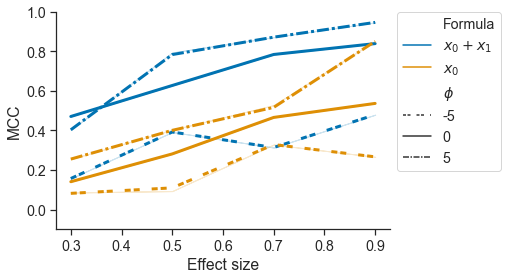

In [272]:
sns.set(style="ticks", font_scale=1.3)

g = sns.lineplot(data=tree_agg_df[tree_agg_df["reg_method"] != "x_1_mult"], x="effect_size", y="mcc",
                 hue="reg_method",
                 palette="colorblind",
                 style="phi",
                 legend=True,
                 ci=False,
                 dashes=[(2,1,2,4), "", (4,1,1,1)],
                 lw=3
            )
g.set(ylim=[-0.1,1])
sns.despine()
h,l = g.get_legend_handles_labels()
g.legend(handles=h, labels=["Formula", r"$x_0 + x_1$", r"$x_0$", r"$\phi$", "-5", "0", "5"], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.xlabel("Effect size")
plt.ylabel("MCC")
plt.savefig(plot_path + "2_cov_mcc.svg", bbox_inches="tight", format="svg")
plt.show()


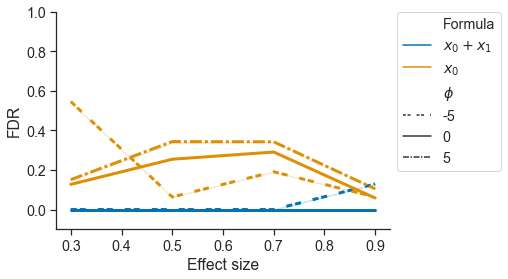

In [273]:
g = sns.lineplot(data=tree_agg_df[tree_agg_df["reg_method"] != "x_1_mult"], x="effect_size", y="fdr",
                 hue="reg_method",
                 palette="colorblind",
                 style="phi",
                 legend=True,
                 ci=False,
                 dashes=[(2,1,2,4), "", (4,1,1,1)],
                 lw=3
            )
g.set(ylim=[-0.1,1])
sns.despine()
h,l = g.get_legend_handles_labels()
g.legend(handles=h, labels=["Formula", r"$x_0 + x_1$", r"$x_0$", r"$\phi$", "-5", "0", "5"], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.xlabel("Effect size")
plt.ylabel("FDR")
plt.savefig(plot_path + "2_cov_fdr.svg", bbox_inches="tight", format="svg")
plt.show()

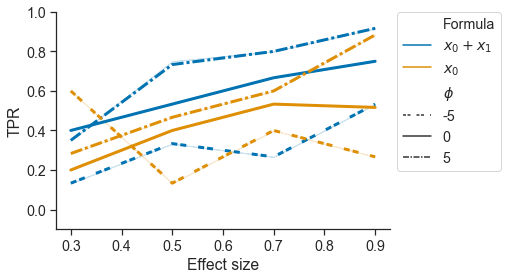

In [274]:
g = sns.lineplot(data=tree_agg_df[tree_agg_df["reg_method"] != "x_1_mult"], x="effect_size", y="tpr",
                 hue="reg_method",
                 palette="colorblind",
                 style="phi",
                 legend=True,
                 ci=False,
                 dashes=[(2,1,2,4), "", (4,1,1,1)],
                 lw=3
            )
g.set(ylim=[-0.1,1])
sns.despine()
h,l = g.get_legend_handles_labels()
g.legend(handles=h, labels=["Formula", r"$x_0 + x_1$", r"$x_0$", r"$\phi$", "-5", "0", "5"], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.xlabel("Effect size")
plt.ylabel("TPR")
plt.savefig(plot_path + "2_cov_tpr.svg", bbox_inches="tight", format="svg")
plt.show()

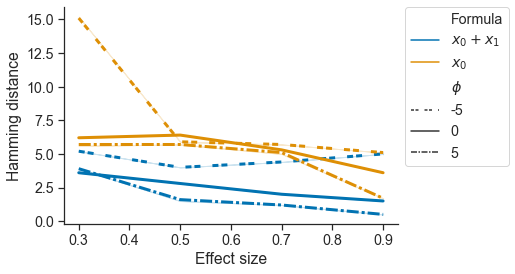

In [275]:
g = sns.lineplot(data=tree_agg_df[tree_agg_df["reg_method"] != "x_1_mult"], x="effect_size", y="hamming",
                 hue="reg_method",
                 palette="colorblind",
                 style="phi",
                 legend=True,
                 ci=False,
                 dashes=[(2,1,2,4), "", (4,1,1,1)],
                 lw=3
            )
# g.set(ylim=[-0.1,1])
sns.despine()
h,l = g.get_legend_handles_labels()
g.legend(handles=h, labels=["Formula", r"$x_0 + x_1$", r"$x_0$", r"$\phi$", "-5", "0", "5"], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.xlabel("Effect size")
plt.ylabel("Hamming distance")
plt.savefig(plot_path + "2_cov_hamming.svg", bbox_inches="tight", format="svg")
plt.show()

In [271]:
freqs = pd.DataFrame()

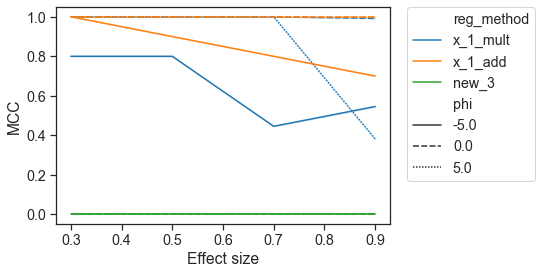

In [265]:
sns.set(style="ticks", font_scale=1.3)

g = sns.lineplot(data=tree_agg_df, x="effect_size", y="tpr2",
                 hue="reg_method",
                 palette="tab10",
                 style="phi",
                 legend=True,
                 ci=False
            )
g.set(ylim=[-0.05, 1.05])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,)
plt.xlabel("Effect size")
plt.ylabel("MCC")
plt.show()

In [223]:
print(tree_agg_df.loc[
          (tree_agg_df["reg_method"] == "x_1_add") &
          (tree_agg_df["effect_size"] == 0.9) &
          (tree_agg_df["phi"] == 0),
    ["reg_method", "effect_size", "phi", "result_nodes", "result_otus", "dataset_id"]
      ])

  reg_method  effect_size  phi       result_nodes  \
0    x_1_add          0.9  0.0  ['7', '33', '39']   
1    x_1_add          0.9  0.0  ['7', '33', '39']   
2    x_1_add          0.9  0.0       ['33', '39']   
3    x_1_add          0.9  0.0  ['7', '33', '39']   
4    x_1_add          0.9  0.0  ['0', '33', '39']   
5    x_1_add          0.9  0.0       ['33', '39']   
6    x_1_add          0.9  0.0       ['33', '39']   
7    x_1_add          0.9  0.0       ['33', '39']   
8    x_1_add          0.9  0.0  ['7', '33', '39']   
9    x_1_add          0.9  0.0       ['33', '39']   

                                         result_otus  dataset_id  
0  [7, 13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49...          30  
1  [7, 13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49...          31  
2  [13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...          32  
3  [7, 13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49...          33  
4  [0, 13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49...          34  
5  [13, 14, 15

In [224]:
all_r = {}
for i in os.listdir(tree_agg_path + "exact_results"):
    with open(tree_agg_path + f"exact_results/{i}", "rb") as f:
        r_ = pkl.load(f)
        all_r.update(r_)

In [225]:
print(all_r.keys())

dict_keys([(30, 'tree_agg', 'x_1_add', None, 0.0), (31, 'tree_agg', 'x_1_add', None, 0.0), (32, 'tree_agg', 'x_1_add', None, 0.0), (33, 'tree_agg', 'x_1_add', None, 0.0), (34, 'tree_agg', 'x_1_add', None, 0.0), (35, 'tree_agg', 'x_1_add', None, 0.0), (36, 'tree_agg', 'x_1_add', None, 0.0), (37, 'tree_agg', 'x_1_add', None, 0.0), (38, 'tree_agg', 'x_1_add', None, 0.0), (39, 'tree_agg', 'x_1_add', None, 0.0), (30, 'tree_agg', 'x_1_add', None, 5.0), (31, 'tree_agg', 'x_1_add', None, 5.0), (32, 'tree_agg', 'x_1_add', None, 5.0), (33, 'tree_agg', 'x_1_add', None, 5.0), (34, 'tree_agg', 'x_1_add', None, 5.0), (35, 'tree_agg', 'x_1_add', None, 5.0), (36, 'tree_agg', 'x_1_add', None, 5.0), (37, 'tree_agg', 'x_1_add', None, 5.0), (38, 'tree_agg', 'x_1_add', None, 5.0), (39, 'tree_agg', 'x_1_add', None, 5.0), (30, 'tree_agg', 'new_3', None, -5.0), (31, 'tree_agg', 'new_3', None, -5.0), (32, 'tree_agg', 'new_3', None, -5.0), (33, 'tree_agg', 'new_3', None, -5.0), (34, 'tree_agg', 'new_3', None, -

In [232]:
test_r = all_r[(39, "tree_agg", "x_1_add", None, 5)]
test_r[2].loc["x_1_node", :]

,Final Parameter,Median,HDI 3%,HDI 97%,SD,Delta,Is significant
Node,,,,,,,
24,0.000,-0.025,-0.648,0.453,0.274,0.121109,False
25,0.000,0.001,-0.746,0.733,0.349,0.121109,False
26,0.000,0.003,-0.501,0.496,0.240,0.121109,False
27,0.000,-0.014,-0.369,0.302,0.160,0.121109,False
28,0.000,-0.004,-0.496,0.372,0.211,0.121109,False
29,0.000,0.000,0.000,0.000,0.000,0.000000,False
0,0.000,0.003,-0.474,0.468,0.238,0.121109,False
1,0.000,-0.044,-0.490,0.331,0.206,0.121109,False
2,0.000,-0.013,-0.463,0.300,0.191,0.121109,False
